<h1>Bioinformatics Final Project</h1>
*disclaimer* cleaning and organizing the data will take a couple hours to finish

In [1]:
# Imports for project
from io import BytesIO
import shutil
from ftplib import FTP
import requests
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import time
from IPython.display import clear_output
import random as r

# Controller for project

# Global Variables
helixPop = {'Right-handed alpha':0, 'Right-handed omega':0, 'Right-handed pi':0 ,
            'Right-handed gamma':0, 'Right-handed 3 - 10':0, 'Left-handed alpha':0, 
            'Left-handed omega':0, 'Left-hended gamma':0, '2 - 7 ribbon/helix':0, 'Polyproline':0}

# get list of protein IDs to retrieve
with open('cullpdb_pc30_res3.0_R1.0_d191017_chains18877.gz') as fin: # get the list of ID's from the file
    IDs = []
    for line in fin:
        IDs += [line.split()[0].lower()]
IDs = IDs[1:] # remove file header

def getDF(idIn):
    #import gzip### set up retreival of pdb file using input code
    #ftp = FTP('ftp.wwpdb.org')
    #ftp.login('username', 'password')
    #flo = BytesIO()
    #
    pdbID = idIn[0:4]
    chain = idIn[4]
    print('reading', pdbID)
    
    #
    #path = '/pub/pdb/data/structures/divided/pdb/'
    #
    #ftp.cwd(path + pdbID[1:3])
    ##print('Retrieving pdb file for', pdbID)
    #ftp.retrbinary('RETR pdb' + pdbID + '.ent.gz', flo.write)
    ##print('File found')
    #flo.seek(0)
    #
    ##print('Decompressing file')
    #with open(pdbID + '.pdb', 'wb') as fout, gzip.GzipFile(fileobj = flo) as gzip:
    #    shutil.copyfileobj(gzip, fout)
    ##print('Done')
    
    seq = ""
    helix = []
    sheet = []
    atom = []
    
    # extract data for the provided chain using html request
    connected = False
    while not connected: 
        try:
            fin = requests.get('https://files.rcsb.org/view/'+ pdbID +'.pdb', stream=True)
            connected = True
        except:
            print('Problem encountered connecting to server. Retrying...')
    #print(fin.text)
    for line in fin.iter_lines():
        line = line.decode('utf-8')
        #print(line)
        if line[0:6] == 'SEQRES' and line[11].lower() == chain:
            seq += line[19:]
        if line[0:6] == 'HELIX ' and line[19].lower() == chain:
            helix.append(line.split())
        if line[0:6] == 'SHEET ' and line[21].lower() == chain:
            sheet.append(line.split())
        if line[0:6] == 'ATOM  ' and line[21].lower() == chain:
            atom.append([line[0:6], line[6:11], line[13:15], line[16], line[17:20],
                         line[21], line[22:26], line[26], line[30:38], line[38:46], line[47:54]])
        if line[0:6] == 'HETATM' and line[21].lower() == chain:
            atom.append([line[0:6], line[6:11], line[13:15], line[16], line[17:20],
                         line[21], line[22:26], line[26], line[30:38], line[38:46], line[47:54]])
    seq = seq.split()
    
    
    
    #Remove the pdb file when finished
    #print('Removing pdb file for', pdbID)
    #os.remove(pdbID+'.pdb')
    #print('Done')
    
    if seq == []:
        print('Chain', chain, 'does not exist in protien', pdbID,'or pdb file does not exist. Trying with new ID')
        return []
    else:
        # store info in dataframes, and clean dataframes to contain only desired data
        #print('Creating DataFrames for', pdbID)
        if helix:
            try:
                helix = pd.DataFrame(helix)[[3,5,6,8,9,10]]
                helix.columns = ['initRes', 'initSeq', 'termRes', 'termSeq', 'type', 'length']
            except:
                helix = pd.DataFrame(helix)[[2,4,5,7,8,9]]
                helix.columns = ['initRes', 'initSeq', 'termRes', 'termSeq', 'type', 'length']
        else: helix = pd.DataFrame()
        sheet = pd.DataFrame(sheet)
        atom = pd.DataFrame(atom)[[2,4,6,8,9,10]]
        atom.columns = ['name', 'res', 'seqNum', 'x', 'y', 'z']
        #print('Done')
        #print()
    return [seq, helix, sheet, atom]

def loadDataSRS():
    print('Starting data collection ...')
    proteinData = {}
    start = time.time()
    i = 0
    while i < 100:
        #print(i)
        ID = IDs[r.randrange(len(IDs))]
        try:
            data = getDF(ID)
        except:
            print('Error in retrieving data')
        if data == []:
            continue
        proteinData[ID] = data
        i += 1
        if i % 10 == 0:
            clear_output(wait=True)
            currTime = time.time()-start
            print(round((i / 100), 2)*100, '% done')
            
            print('Time elapsed:',int((currTime/60)/60), 'hours', 
                  int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')
            
            print(i, 'Protiens loaded')
            print()
    clear_output(wait=True)
    currTime = time.time()-start
    
    print('Total time elapsed:',int((currTime/60)/60), 'hours', 
          int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')
    
    return proteinData
                  

#def loadData1():
#    proteinData = {}
#    start = time.time()
#    i = 0
#    for ID in IDs[:int(len(IDs)/2)]:
#        # do analysis here
#        try:
#            data = getDF(ID)
#        except:
#            print('Error in retrieving data')
#        proteinData[ID] = data
#        if i % int((len(IDs)/2)/10) == 0:
#            clear_output(wait=True)
#            currTime = time.time()-start
#            print(round(i / int(len(IDs)/2), 2)*100, '% done')
#            print('Time elapsed:',int((currTime/60)/60), 'hours', int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')
#            print(i, 'Protiens analyzed')
#            print()
#        i += 1
#    clear_output(wait=True)
#    currTime = time.time()-start
#    print('Total time elapsed:',int((currTime/60)/60), 'hours', int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')
#    return proteinData
#                  
#def loadData2():
#    proteinData = {}
#    start = time.time()
#    i = 0
#    for ID in IDs[int(len(IDs)/2):]:
#        # do analysis here
#        try:
#            data = getDF(ID)
#        except:
#            print('Error in retrieving data')
#        proteinData[ID] = data
#        if i % int(int(len(IDs)/2)/10) == 0:
#            clear_output(wait=True)
#            currTime = time.time()-start
#            print(round(i / int(len(IDs)/2), 2)*100, '% done')
#            print('Time elapsed:',int((currTime/60)/60), 'hours', int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')
#            print(i, 'Protiens analyzed')
#            print()
#        i += 1
#    clear_output(wait=True)
#    currTime = time.time()-start
#    print('Total time elapsed:',int((currTime/60)/60), 'hours', int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')
#    return proteinData

<h1>Common Functions</h1>

In [2]:
def angleCalc(p1, p2, p3, p4):
    
    # Equation from http://www.stem2.org/je/proteina.pdf
    
    # Get coordinates for vectors q1, q2 and q3
    q1 = np.subtract(p2,p1) # b - a
    q2 = np.subtract(p3,p2) # c - b
    q3 = np.subtract(p4,p3) # d - c

    # Calculate cross vectors
    q1_x_q2 = np.cross(q1,q2)
    q2_x_q3 = np.cross(q2,q3)

    n1 = q1_x_q2/np.sqrt(np.dot(q1_x_q2,q1_x_q2))
    n2 = q2_x_q3/np.sqrt(np.dot(q2_x_q3,q2_x_q3))

    # Calculate unit vectors
    u1 = n2
    u3 = q2/(np.sqrt(np.dot(q2,q2)))
    u2 = np.cross(u3,u1)

    # Calculate cosine and sine
    cos_theta = np.dot(n1,u1)
    sin_theta = np.dot(n1,u2)

    # Calculate torsion angle
    theta = -math.atan2(sin_theta,cos_theta) # it is different from atan2 from fortran
    theta_deg = np.degrees(theta)

    #Show results
    #print("theta (rad) = ",theta)
    #print("theta (deg) = ",theta_deg)

    # Return torsion angle in degrees
    return theta_deg 

def torsion(a1, a2, a3):
    phi = 0
    psi = 0
    
    #print(a1)
    #print(a2)
    #print(a3)
    
    try:
        p0 = [float(a1[a1['name']=='C ']['x']), float(a1[a1['name']=='C ']['y']), float(a1[a1['name']=='C ']['z'])]
        p1 = [float(a2[a2['name']=='N ']['x']), float(a2[a2['name']=='N ']['y']), float(a2[a2['name']=='N ']['z'])]
        p2 = [float(a2[a2['name']=='CA']['x']), float(a2[a2['name']=='CA']['y']), float(a2[a2['name']=='CA']['z'])]
        p3 = [float(a2[a2['name']=='C ']['x']), float(a2[a2['name']=='C ']['y']), float(a2[a2['name']=='C ']['z'])]
        p4 = [float(a3[a3['name']=='N ']['x']), float(a3[a3['name']=='N ']['y']), float(a3[a3['name']=='N ']['z'])]
    except: 
        print(end='')
        #print('Missing data for one of the amino acids')
        
        #print(p0)
        #print(p1)
        #print(p2)
        #print(p3)
        #print(p4)
    
    #print()
    
    phi = angleCalc(p0, p1, p2, p3)
    psi = angleCalc(p1, p2, p3, p4)
    
    return {'phi':phi, 'psi':psi}

def ramaPlot(points):
    
    for point in points:
        plt.plot(point['psi'], point['phi'])

<h1>Question 1</h1>
    Find the popularity of different kind of helices: read the data set and analyze it to find the
popularity of each type of helices

In [3]:
helixPop = {'Right-handed alpha':0, 'Right-handed omega':0, 'Right-handed pi':0 ,
            'Right-handed gamma':0, 'Right-handed 3 - 10':0, 'Left-handed alpha':0, 
            'Left-handed omega':0, 'Left-hended gamma':0, '2 - 7 ribbon/helix':0, 'Polyproline':0}

def question1(helixType):
    for helix in helixType:
        try: 
            helix = int(helix)
        except:
            helix = int(helix[0])
        if helix == 1:
            helixPop['Right-handed alpha'] += 1
        elif helix == 2:
            helixPop['Right-handed omega'] += 1
        elif helix == 3:
            helixPop['Right-handed pi'] += 1
        elif helix == 4:
            helixPop['Right-handed gamma'] += 1
        elif helix == 5:
            helixPop['Right-handed 3 - 10'] += 1
        elif helix == 6:
            helixPop['Left-handed alpha'] += 1
        elif helix == 7:
            helixPop['Left-handed omega'] += 1
        elif helix == 8:
            helixPop['Left-hended gamma'] += 1
        elif helix == 9:
            helixPop['2 - 7 ribbon/helix'] += 1
        elif helix == 10:
            helixPop['Polyproline'] += 1

<h1>Question 2</h1>
Analyze the amino acids that prefer to form/be part of helices. Does an AA prefer to
form/be part of specific type of helices?

<h1>Question 3</h1>
Analyze the length of helices (in terms of number of AAs). Is there any relation between
the type of a helix and its length?

<h1>Question 4</h1>
Analyze the torsion angles in each type of helices. Build something similar to
Ramachandran plot but for different types of helices.

In [4]:
helixTorsion = {'Right-handed alpha':[], 'Right-handed omega':[], 'Right-handed pi':[],
            'Right-handed gamma':[], 'Right-handed 3 - 10':[], 'Left-handed alpha':[], 
            'Left-handed omega':[], 'Left-hended gamma':[], '2 - 7 ribbon/helix':[], 'Polyproline':[]}

def question4(helices, atoms):
    for index, rowHel in helices.iterrows(): # iterate through the helices in the protein
        try: 
            hType = int(rowHel['type']) # save the type of the current helix 
        except:
            hType = int(rowHel['type'][0]) # save the type of the current helix 
        
        helixAtoms = atoms[np.logical_and(int(rowHel['initSeq']) <= atoms['seqNum'].astype(int)
                                          , atoms['seqNum'].astype(int) <= int(rowHel['termSeq']))]
        
        #print(rowHel['initSeq'], rowHel['termSeq'])
        #print(helixAtoms)
        
        for i in range(int(rowHel['initSeq']), int(rowHel['termSeq'])+1): # iterate through atoms
            #print(i)
            #print()

            a1 = atoms[atoms['seqNum'].astype(int) == i-1]
            a2 = atoms[atoms['seqNum'].astype(int) == i]
            a3 = atoms[atoms['seqNum'].astype(int) == i+1]
            
            #print(a1, a2, a3, end='\n')
            
            try:
                if hType == 1:
                    helixTorsion['Right-handed alpha'].append(torsion(a1, a2, a3))
                elif hType == 2:
                    helixTorsion['Right-handed omega'].append(torsion(a1, a2, a3))
                elif hType == 3:
                    helixTorsion['Right-handed pi'].append(torsion(a1, a2, a3))
                elif hType == 4:
                    helixTorsion['Right-handed gamma'].append(torsion(a1, a2, a3))
                elif hType == 5:
                    helixTorsion['Right-handed 3 - 10'].append(torsion(a1, a2, a3))
                elif hType == 6:
                    helixTorsion['Left-handed alpha'].append(torsion(a1, a2, a3))
                elif hType == 7:
                    helixTorsion['Left-handed omega'].append(torsion(a1, a2, a3))
                elif hType == 8:
                    helixTorsion['Left-hended gamma'].append(torsion(a1, a2, a3))
                elif hType == 9:
                    helixTorsion['2 - 7 ribbon/helix'].append(torsion(a1, a2, a3))
                elif hType == 10:
                    helixTorsion['Polyproline'].append(torsion(a1, a2, a3))
            except:
                #print('problem analyzing angle')
                print(end='')
        #print()

<h1>Question 5</h1>
Analyze the amino acids that prefer to form/be part of beta-sheets. Analyze the number
of strands in beta-sheets.

<h1>Question 6</h1>
Build Ramachandran plot for a given AA.

<h1>Question 7</h1>
Analyze the length of bonds and the angle between different type of backbone atoms in
general and for individual AAs.

<h1>Run questions</h1>

In [5]:
helixPop = {'Right-handed alpha':0, 'Right-handed omega':0, 'Right-handed pi':0 ,
            'Right-handed gamma':0, 'Right-handed 3 - 10':0, 'Left-handed alpha':0, 
            'Left-handed omega':0, 'Left-hended gamma':0, '2 - 7 ribbon/helix':0, 'Polyproline':0}

helixTorsion = {'Right-handed alpha':[], 'Right-handed omega':[], 'Right-handed pi':[],
            'Right-handed gamma':[], 'Right-handed 3 - 10':[], 'Left-handed alpha':[], 
            'Left-handed omega':[], 'Left-hended gamma':[], '2 - 7 ribbon/helix':[], 'Polyproline':[]}

# load data selected by simple random sampling

data = loadDataSRS()

# read and analyze the data

start = time.time()
i = 0
for protein in data:
    i += 1
    try:
        question1(data[protein][1]['type'])
    except:
        print('problem with protein helix', protein)
    
    #print(protein)
    try:
        question4(data[protein][1], data[protein][3])
    except:
        print('problem with protein atom', protein)
        
    if(i% int(len(data)/10) == 0):
        currTime = time.time()-start
        clear_output(wait=True)
        print('Analysis', round((i/len(data)), 2)*100, '% complete')
        print('Time elapsed:',int((currTime/60)/60), 'hours', int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')

#data = loadData1()
#
## run analysis for first half of data
#
#i = 0
#for protein in data:
#    i += 1
#    try:
#        question1(data[protein][1]['type'])
#    except:
#        print('problem with protein', protein)
#    try:
#        question4(data[protein][1], data[protein][3])
#    except:
#        print('problem with protein', protein)
#    if(i%int(len(data)/10) == 0):
#        currTime = time.time()-start
#        clear_output(wait=True)
#        print('Analysis', (i/len(data))*100, '% complete')
#        print('Time elapsed:',int((currTime/60)/60), 'hours', int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')
#
#%reset_selective -f data
#        
#start = time.time()
#i = 0
#for protein in data:
#    i += 1
#    try:
#        question1(data[protein][1]['type'])
#    except:
#        print('problem with protein', protein)
#    try: 
#        question4(data[protein][1], data[protein][3])
#    except:
#        print('problem with protein', protein)
#    if(i%int(len(data)/10) == 0):
#        currTime = time.time()-start
#        clear_output(wait=True)
#        print('Analysis', (i/len(data))*100, '% complete')
#        print('Time elapsed:',int((currTime/60)/60), 'hours', int(currTime/60)%60, 'minutes', int(currTime%60), 'seconds')

#data = loadDataTest()
#
#i = 0
#for protein in data:
#    i += 1
#    try:
#        question1(data[protein][1]['type'])
#    except:
#        clear_output(wait=True)
#        print('given protein has no helix')
#    try:
#        question4(data[protein][1], data[protein][3])
#    except:
#        clear_output(wait=True)
#        print('given protein has no helix')
#    if(len(data)%10 == 0):
#        clear_output(wait=True)
#        print('Analysis', (i/len(data))*100, '% complete')

for entry in helixPop:
    print(entry, ':', helixPop[entry])
for entry in helixTorsion:
    print(entry, ':', len(helixTorsion[entry]))

Analysis 100.0 % complete
Time elapsed: 0 hours 8 minutes 10 seconds
Right-handed alpha : 817
Right-handed omega : 0
Right-handed pi : 0
Right-handed gamma : 0
Right-handed 3 - 10 : 264
Left-handed alpha : 0
Left-handed omega : 0
Left-hended gamma : 0
2 - 7 ribbon/helix : 0
Polyproline : 0
Right-handed alpha : 10689
Right-handed omega : 0
Right-handed pi : 0
Right-handed gamma : 0
Right-handed 3 - 10 : 1224
Left-handed alpha : 0
Left-handed omega : 0
Left-hended gamma : 0
2 - 7 ribbon/helix : 0
Polyproline : 0


<h1>Question 1 Output</h1>

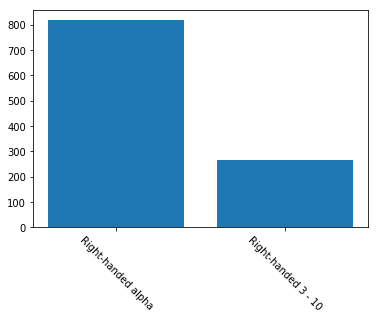

In [6]:
q1Data = {}
for entry in helixPop:
    if helixPop[entry] > 0:
        q1Data[entry] = helixPop[entry]

plt.bar(q1Data.keys(), q1Data.values())
plt.xticks(rotation=-45)
plt.title('Helix Pop')
plt.show()

<h1>Question 4 Output</h1>

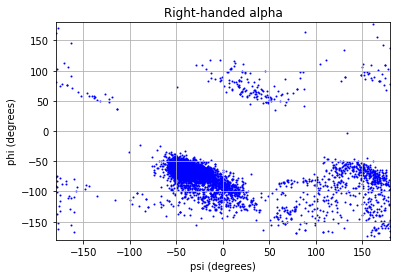

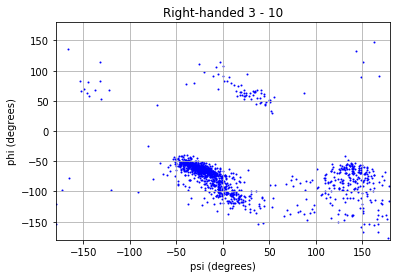

In [7]:
count = 0
for entry in helixTorsion:
    if len(helixTorsion[entry]) > 0:
        count += 1
        plt.xlim(-180, 180)
        plt.ylim(-180, 180)
        plt.grid(True, 'major')
        plt.title(entry)
        plt.xlabel('psi (degrees)')
        plt.ylabel('phi (degrees)')
        for point in helixTorsion[entry]:
            plt.scatter(point['psi'], point['phi'], s=1, c='b')
        plt.show()